### Analysis

Task: Identifying the cartoon character from a image

Task: Identifying the cartoon character from a image
Objectives: Based on a image with a character, the algortihm should find it s name (it can be done only for the following characters: donald, mickey, minion, olaf, pooh, powerpuff, and pumba)

Framing the problem: Supervised learning, our dataset containts images with 7 cartoon characters that are labeled

Measuring the performance: Model's accuracy and Visual Human Evaluation

### Get the data

The data we have is a combination of 2 datasets that can be found in Kaggle: the [Disney characters dataset](https://www.kaggle.com/datasets/sayehkargari/disney-characters-dataset) and the [Powerpuff Girls dataset](https://www.kaggle.com/datasets/nataliacanto/powerpuff-girls).

A folder is created for each character's images and there is an additional folder for images used later to showcase a model's performance. Each image is in either JPG, JPEG, or PNG format.

A function is defined to load the images and process the images from the dataset. The function ensures that the image has the 3 RGB color channels and resizes all images by default to 128x128 format to ensure the data is in a consistent format. Each image is returned as a NumPy array with normalized pixel values in the range [0, 1]. The normalization is needed for later processing and model raining.

In [1]:
import os
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage import color
from skimage.feature import hog
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

In [2]:
# Function to load and preprocess images
def load_and_preprocess_image(file_path, target_size=(128, 128)):
    # Load image
    image = Image.open(file_path).convert('RGB')  # Ensures image has 3 color channels

    # Resize image
    image = image.resize(target_size)

    # Convert image to NumPy array and normalize pixel values to [0, 1] for easier processing
    image_array = np.array(image) / 255.0  

    return image_array

In [3]:
# Folders containing JPEG image files
folders = {
    "donald": "donald",
    "mickey": "mickey",
    "minion": "minion",
    "pooh": "pooh",
    "pumba": "pumba",
    "powerpuff": "powerpuff",
    "olaf" : "olaf"
}

# Parent folder for the showcase dataset
parent_folder = "test"

# Dictionaries to hold image files from each folder
image_files = {
    folder: [file for file in os.listdir(folder) if file.endswith((".jpg", ".jpeg", ".png"))]
    for folder in folders.values()
}

showcase_image_files = {
    folder: [file for file in os.listdir(os.path.join(parent_folder, folder)) if file.endswith((".jpg", ".jpeg", ".png"))]
    for folder in folders.values()
}

# Empty lists to store image data and labels
dataset = []
dataset_showcase = []
labels = []
labels_showcase = []

# Iterate over each folder and its image files to load and preprocess the images
for folder, files in image_files.items():
    for file_name in files:
        file_path = os.path.join(folder, file_name)
        try:
            image_array = load_and_preprocess_image(file_path)
            dataset.append(image_array)
            labels.append(folder) 
        except Exception as e:
            print(f"Failed to process {file_path}: {str(e)}")

# Iterate over test folder and its image files to load and preprocess the images
for folder, files in showcase_image_files.items():
    for file_name in files:
        file_path = os.path.join(parent_folder, folder, file_name)
        try:
            image_array = load_and_preprocess_image(file_path)
            dataset_showcase.append(image_array)
            labels_showcase.append(folder) 
        except Exception as e:
            print(f"Failed to process {file_path}: {str(e)}")

c:\Users\uafa6\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### 3. Explore the data

After acquiring image data, they are initially stored in lists with their labels kept separate, facilitating flexible preprocessing steps. The dataset is organized into training and test sets from the beginning to ensure that the model can be accurately evaluated on unseen data.


Each image undergoes resizing to a uniform size of 128x128 pixels and is converted to have three color channels (RGB). Post-resizing, the images are stored as NumPy arrays, which brings several benefits:
- **Efficiency and Speed:** NumPy arrays are stored in contiguous memory blocks, allowing faster access and efficient computation, which is crucial when dealing with large volumes of image data.

- **Compatibility:** Using NumPy arrays ensures that the data is compatible with various machine learning and data processing libraries, such as TensorFlow and Scikit-learn, which expect data in this format.

In [4]:
# Convert each list of image arrays to a NumPy array
dataset = np.array(dataset)
dataset_showcase = np.array(dataset_showcase)

print("Shape of the dataset:", dataset.shape)

Shape of the dataset: (466, 128, 128, 3)


##### **Array Structure**
Each image is represented as a 3D NumPy array, with dimensions reflecting the image's height, width, and color channels. Specifically, the shape of the array is (128, 128, 3), where 128x128 represents that pixel dimensions, and 3 stands for the RGB color channels that is stored as three values within each pixel's array entry.
The pixel values, which originally range from 0 to 255 (the range that each color component can take in an 8-bit image), are normalized to a range of 0 to 1.

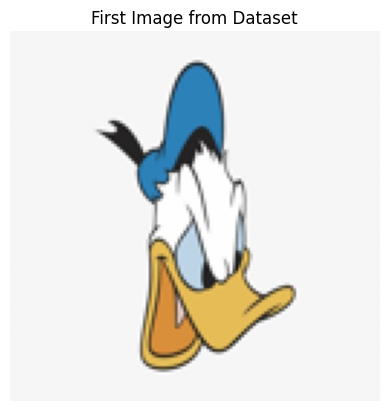

Shape of the first image: (128, 128, 3)
Data type of the first image: float64
Pixel values in the top-left corner of the image:
[[[0.96470588 0.96470588 0.96470588]
  [0.96470588 0.96470588 0.96470588]]

 [[0.96470588 0.96470588 0.96470588]
  [0.96470588 0.96470588 0.96470588]]] 

Detailed values of the first pixel (top-left corner):
Red channel value: 0.9647058823529412
Green channel value: 0.9647058823529412
Blue channel value: 0.9647058823529412


In [5]:
first_image = dataset[0]

# Display the image
plt.imshow(first_image)
plt.title('First Image from Dataset')
plt.axis('off')
plt.show()

# Print the shape and type of the first image
print("Shape of the first image:", first_image.shape)
print("Data type of the first image:", first_image.dtype)

# Print the pixel values for the top-left corner of the image
print("Pixel values in the top-left corner of the image:")
print(first_image[0:2, 0:2, :], '\n')  # Show a 2x2 area from the top-left corner

# Break down of the first pixel (top-left corner)
print("Detailed values of the first pixel (top-left corner):")
print("Red channel value:", first_image[0, 0, 0])
print("Green channel value:", first_image[0, 0, 1])
print("Blue channel value:", first_image[0, 0, 2])

### 4. Prepare the data

Helping function to visualize the image

In [6]:
def visualize_image(segmented_image, title):
    plt.imshow(segmented_image, cmap='viridis')  # 'viridis' is a good colormap to differentiate clusters
    plt.title(title)
    plt.axis('off')
    plt.show()

#### Segmenting the image
Segmenting the image using K-means clustering. 
Number of clusters = 2 because we have 2 clusters: the background and the character. It takes an image array as input and returns a segmented image where each pixxel is labeled according to the cluster it belongs to. 

In [7]:
def segment_image_using_kmeans(image_array):
    # Reshape the image to a 2D array of pixels
    pixels = image_array.reshape(-1, 3)

    # Apply K-means clustering with specified initial centroids
    kmeans = KMeans(n_clusters=2, n_init=1, random_state=42)
    labels = kmeans.fit_predict(pixels)

    # Reshape the labels back into the original image shape
    segmented_image = labels.reshape(image_array.shape[0], image_array.shape[1])

    return segmented_image



#### Converting to grayscale

It  takes a segmented image as input and normalizes its values to the range 0-255, mapping 0 to black and 1 to white in our case , effectively converting it to a grayscale image. By converting the segmented image to grayscale, we can visualize 
the segmentation results more clearly, making it easier to identify distinct regions and boundaries.

In [8]:
def convert_to_grayscale(segmented_image):
    max_label = segmented_image.max()
    min_label = segmented_image.min()
    grayscale_image = ((segmented_image - min_label) / (max_label - min_label)) * 255
    # By converting the grayscale image to uint8, we reduce the memory required to store each pixel value from 64 bits to 8 bits.
    grayscale_image = grayscale_image.astype(np.uint8)
    return grayscale_image

#### Converting to binary

Converting segmented image into a binary mask using a treshold value. 
Pixels with intensities greater than or equal to the threshold value are set to 1, 
while pixels with intensities below the threshold are set to 0.
Binary masks is used to define regions of interest in images, such as the location of objects or shapes, in our case the character.

In [9]:
def convert_to_binary(segmented_image, threshold):
    # Convert segmented_image to a numerical dtype
    segmented_image = segmented_image.astype(np.uint8)
    
    if(segmented_image[0,0] > 127):
        binary_mask = np.where(segmented_image <= threshold, 255, 0).astype(np.uint8)
    else:
        binary_mask = np.where(segmented_image >= threshold, 255, 0).astype(np.uint8)

    # Apply thresholding to convert the segmented image to a binary mask
    return binary_mask

#### Morphological operations

Done on the binary mask, aiming to refine it. It ensures that the border of the charcater is joined. The size of the kernel sets how much border we want to include. 

Kernel specifies the shape of the region over which dilation is applied. 

The dilate function adds pixels to the boundaries of objects in the image -> enlarges the white regions (the character). 2 iterations means that the dilation will be performed twice -> it will connect more of the nearby white regions

Erosion helpswith removing noise and smooths the boundaries of the object (cartoon character)

In [10]:
def apply_morphological_operations(binary_mask):
    # Apply morphological operations to refine the binary mask
    kernel = np.ones((5, 5), np.uint8)
    # Perform dilation to connect nearby pixels of the same value
    dilated_mask = cv2.dilate(binary_mask, kernel, iterations=2)
    # Removes pixels from the boundaries of objects, effectively shrinking them.
    eroded_mask = cv2.erode(dilated_mask, kernel)
    return eroded_mask

#### Extracting the character
Extracting the character from the original image based on the binary_mask. The background will be set to 0. 

In [11]:
def extract_character(image_array, binary_mask):
    # Convert the binary mask to a boolean mask where True represents the character region
    character_mask = binary_mask.astype(bool)
    
    # Create an empty array with the same shape as the original image
    character_image = np.zeros_like(image_array)
    
    # Apply the mask to each color channel
    for i in range(3):
        character_image[:,:,i] = image_array[:,:,i] * character_mask
    
    return character_image

#### Applying all the above functions to see how does it perform on a image

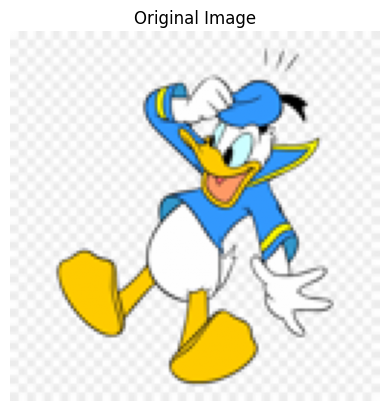

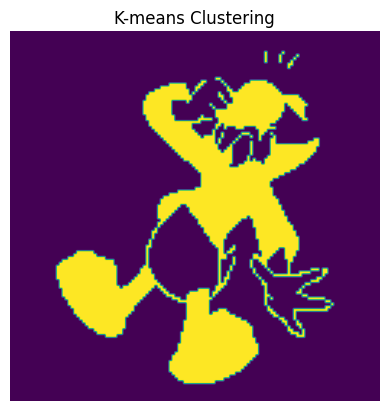

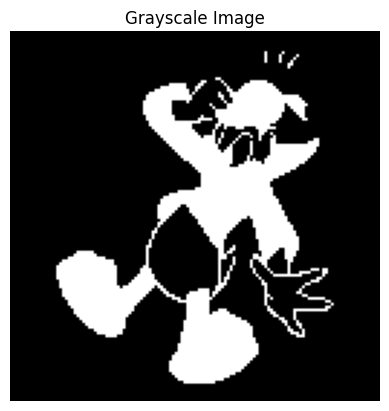

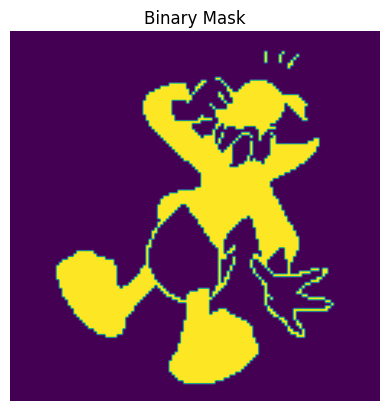

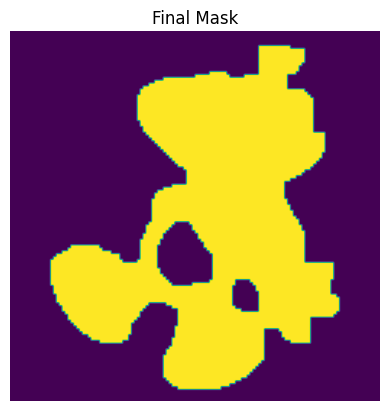

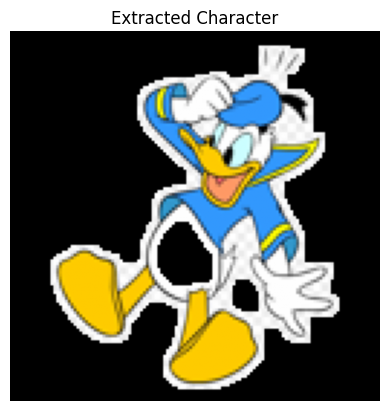

In [12]:
image = dataset[1]

visualize_image(image, 'Original Image')

segmented_image = segment_image_using_kmeans(image)
visualize_image(segmented_image, 'K-means Clustering')

gray_image = convert_to_grayscale(segmented_image)
plt.imshow(gray_image, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

binary_mask = convert_to_binary(gray_image, 150)
visualize_image(binary_mask, 'Binary Mask')

final_mask = apply_morphological_operations(binary_mask)
visualize_image(final_mask, 'Final Mask')


character_image = extract_character(image, final_mask)

plt.imshow(character_image)
plt.title('Extracted Character')
plt.axis('off')
plt.show()


#### Function that takes the dataset and extracts all the characters from the images

In [13]:
def extract_all_characters_from_image(dataset):

    characters = []
    for image in dataset:
        segmented_image = segment_image_using_kmeans(image)
        gray_image = convert_to_grayscale(segmented_image)
        binary_mask = convert_to_binary(gray_image, 150)
        final_mask = apply_morphological_operations(binary_mask)
        character_image = extract_character(image, final_mask)
        characters.append(character_image)
    return characters

#### Function that takes the dataset and extracts one character from the image

In [14]:
def extract_character_from_image(image):
    segmented_image = segment_image_using_kmeans(image)
    gray_image = convert_to_grayscale(segmented_image)
    binary_mask = convert_to_binary(gray_image, 150)
    final_mask = apply_morphological_operations(binary_mask)
    character_image = extract_character(image, final_mask)
    return character_image

Extracting all characters and displaying the first 5 

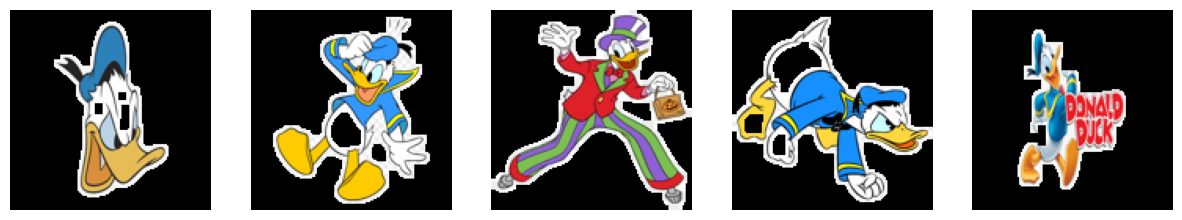

In [15]:
extracted_characters = extract_all_characters_from_image(dataset)

# Display the first 5 extracted characters
plt.figure(figsize=(15, 5))
for i, character in enumerate(extracted_characters[:5]):

    resized_character = resize(character, (128,128))
    plt.subplot(1, 5, i + 1)
    plt.imshow(resized_character, cmap='gray')
    plt.axis('off')
plt.show()

#### Features

The cartoon images have 2 features: their colors and their shapes. 

hog features(the shapes) - it extracts HOG features from the image. It's purpouse is to detect the object and capture the edge of it.

color_histogram - capturing the color distribution of the image. It represents the distribution of colors in an image. For each color channel(0,1 and 2), it computes a histogram with a specified number of bins and normalizes it.

In [16]:
def extract_hog_features(image, pixels_per_cell=(16, 16), cells_per_block=(1, 1), orientations=9):
    # Convert to grayscale if RGB, check if image is already grayscale
    if image.ndim == 3:
        image = color.rgb2gray(image)
    # Extract HOG features, specifying that the input image is grayscale so no channel_axis is needed
    features = hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell,
                           cells_per_block=cells_per_block, visualize=False, feature_vector=True)
    return features

def extract_color_histogram(image, bins=256):
    # Convert image to uint8 if it's not already
    if image.dtype != np.uint8:
        image = np.uint8(image * 255)
    hist = []
    for i in range(3):  # Compute histogram for each color channel
        hist_channel = cv2.calcHist([image], [i], None, [bins], [0, 256])
        cv2.normalize(hist_channel, hist_channel)
        hist.append(hist_channel)
    return np.concatenate(hist).flatten()

def extract_combined_features(image):
    hog_features = extract_hog_features(image)
    color_features = extract_color_histogram(image)
    return np.concatenate((hog_features, color_features))

Saving all the feature vectors as a NumPy array

In [17]:
# Create an empty list to store feature vectors
character_features = []

# Loop through each image in the dataset
for image in extracted_characters:
    features = extract_combined_features(image)
    character_features.append(features)

# Convert the list of feature vectors to a NumPy array
character_features_array = np.array(character_features)

character_features_array is an array of one-dimensional array. Therefore we need to flatten it.

In [18]:
# Flatten all images
flattened_character_images = []
for character in character_features_array:
    flattened_image = character.flatten()
    flattened_character_images.append(flattened_image)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(flattened_character_images, labels, test_size=0.2, random_state=42,stratify=labels)

### 5 Train Models

**K-nearest neighbours**

K-Nearest Neighbors (KNN) is a simple and effective machine learning algorithm used for classification and regression tasks. It classifies a data point based on how its neighbors are classified.

- **Number of Neighbors (k)**: Represents the number of nearest neighbors to consider for determining the class of a data point. A smaller k can be noisy and subject to overfitting, while a larger k can be computationally heavy and may underfit the data.
- **Distance Metric**: The method used to measure the distance between data points. Common metrics include Euclidean distance and Manhattan distance.

A KNN model with different values of k and distance metrics is trained and evaluated with cross-validation to help in identifying the best combination of hyperparameters for the model.

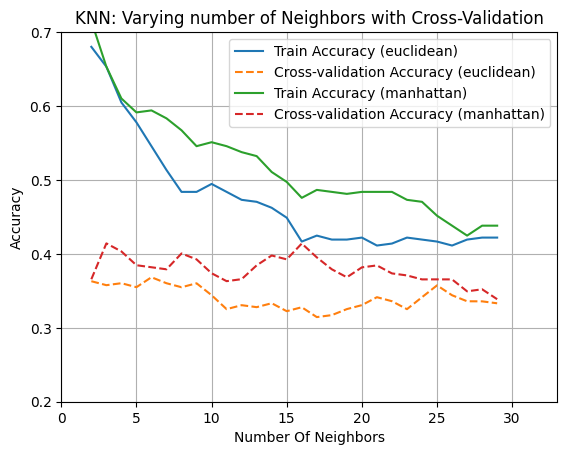

In [19]:
# Train the classifier with different values of k and distance metrics to find the best hyperparameters

train_score = {}
cv_score = {}
n_neighbors = np.arange(2, 30, 1)
metrics = ['euclidean', 'manhattan']

for metric in metrics:
    
    train_score[metric] = {}
    cv_score[metric] = {}

    for neighbor in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=neighbor, metric=metric)
        knn.fit(X_train, y_train)
        train_score[metric][neighbor] = knn.score(X_train, y_train)
        # 5 fold cross-validation
        cv_results = cross_val_score(knn, X_train, y_train, cv=5) 
        cv_score[metric][neighbor] = cv_results.mean()

# Plot the results
for metric in metrics:
    plt.plot(n_neighbors, train_score[metric].values(), label=f"Train Accuracy ({metric})")
    plt.plot(n_neighbors, cv_score[metric].values(), label=f"Cross-validation Accuracy ({metric})", linestyle='--')

plt.xlabel("Number Of Neighbors")
plt.ylabel("Accuracy")
plt.title("KNN: Varying number of Neighbors with Cross-Validation")
plt.legend()
plt.xlim(0, 33)
plt.ylim(0.20, 0.70)
plt.grid()
plt.show()


The Manhattan distance metric is chosen as it is less influenced by large individual differences in the image feature values and provides slightly better results.

In [20]:
knn = KNeighborsClassifier(n_neighbors=15 , metric='manhattan')

# Train the model
knn.fit(X_train, y_train)

# Perform 5 fold cross-validation
scores = cross_val_score(knn, X_train, y_train, cv=5) 

# Calculate the average accuracy
average_accuracy = scores.mean()

print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Average Accuracy: 39.26%


The average accuracy of the model (39.52%) showes it is not able to properly capture the patterns in the data. A potential reasoning for why this model is not fit for the task is the fact that KNN struggles with high-dimensional data due to the curse of dimensionality, where the distance metric becomes less meaningful.

**Support Vector Machine**

SVM is a machine learning algorithm used for classification and regression tasks. It works by mapping data into a high-dimensional space where a hyperplane can be used to separate different classes. This process involves finding a plane that has the maximum margin, or distance, between data points of different classes.

Key Parameters in SVM:
- **C (Regularization Parameter):** this controls how much the SVM should avoid misclassifying each training example. A higher value of C tells the model to try harder to get the training set correct, which can be strict but might ignore the overall trend. A lower value makes the boundary smoother and more generalized.
- **Gamma:** This determines how much influence a single example has. A low gamma means far reach, and a high gamma means close reach. This helps in deciding how tightly or loosely to draw the boundary around clusters of data.
- **Kernel:** The kernel decides the shape of the boundary that separates the data. Choices like linear, polynomial, and radial basis function (RBF) allow the SVM to adapt to different arrangements and complexities of data.

Grid search was implemented to find the best combination of parameters for a model. It works by systematically trying out different combinations of parameters, assessing each combination's performance using a specific metric, typically through cross-validation.

In [21]:
param_grid = {
    'C': [0.1, 1, 10, 100],  # Example C values
    'gamma': [0.001, 0.01, 0.1, 1],  # Example Gamma values
    'kernel': ['rbf', 'poly', 'linear']  # Example kernels
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

print("Best parameters found:", best_parameters)

model = SVC(gamma=00.1, kernel='linear', C=0.1, random_state=42)
model.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Calculate the average accuracy
average_accuracy = scores.mean()

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

Best parameters found: {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'}
Average Accuracy: 49.18%


The 50% accuracy achieved by the SVM model suggests that it may not be the most effective choice for this particular dataset. This performance could be due to significant overlap among the classes, which complicates the SVM's ability to find a clear margin of separation. Such overlap is particularly challenging for SVM when the problem is non-linear and the distinguishing features are insufficient for straightforward classification.

**Random Tree Forest**

A decision tree is a simple, tree-like model used to make predictions by splitting data into branches based on feature values. Each node in the tree represents a decision point, leading to a final prediction at the leaves.

Random Forest creates an ensemble of multiple decision trees, each trained on different random subsets of the data. In the prediction phase, each tree in the forest makes its own prediction. For classification tasks, the final prediction is determined by a majority vote among the trees.


Key Parameters in Random Forest:

- **n_estimators:** This is the number of trees in the forest. Generally, more trees increase the model's accuracy but also increase the computational complexity.
- **max_depth:** The maximum depth of the trees. Limiting the depth of each tree helps prevent overfitting but can lead to a simpler model that underperforms.
- **max_features:** The number of features to consider when looking for the best split. Using more features can increase the model's performance but also makes the training process more computationally expensive.

In [22]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 50, 100],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)

forest = RandomForestClassifier(n_estimators = 300, max_depth = 50, max_features = 'log2', random_state = 42)
forest.fit(X_train, y_train)

# Perform cross-validation
scores = cross_val_score(forest, X_train, y_train, cv=5)  # cv=5 specifies 5-fold cross-validation

# Calculate the average accuracy
average_accuracy = scores.mean()

# Print the average accuracy
print(f"Average Accuracy: {average_accuracy*100:.2f}%")

y_pred = forest.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Best parameters: {'max_depth': 50, 'max_features': 'log2', 'n_estimators': 300}
Average Accuracy: 70.69%
Test Accuracy: 67.02%


The higher accuracy with suggests that the Random Forest may be more suitable for this dataset, particularly if it deals with overlapping classes or features with complex relationships that a simpler model like SVM struggles with. The ensemble approach of using multiple decision trees allows Random Forest to capture a broader range of data characteristics, reducing the impact of noise and outliers compared to single decision tree models.

### Use the pictures in the test folder to visualise the best model's performance

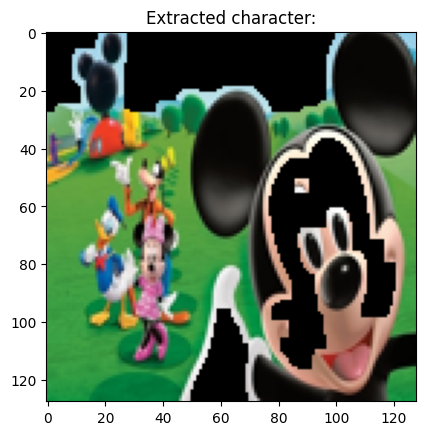

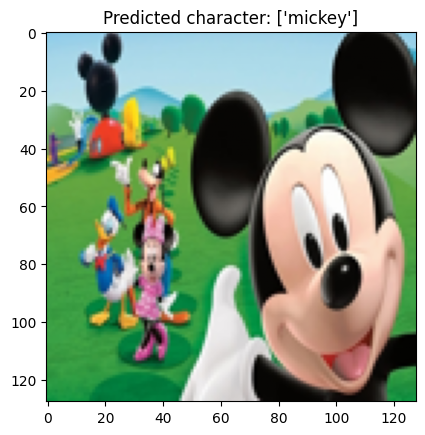

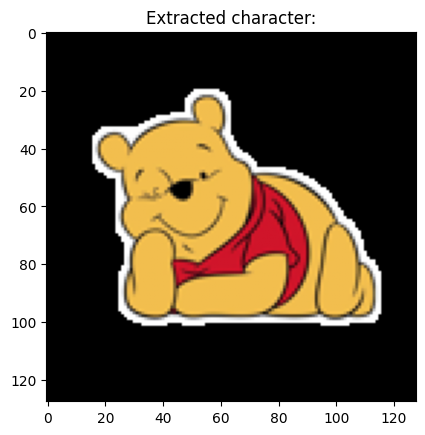

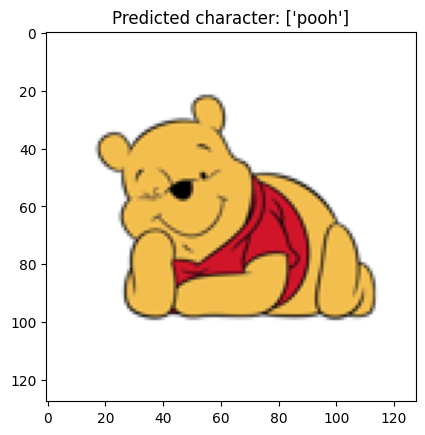

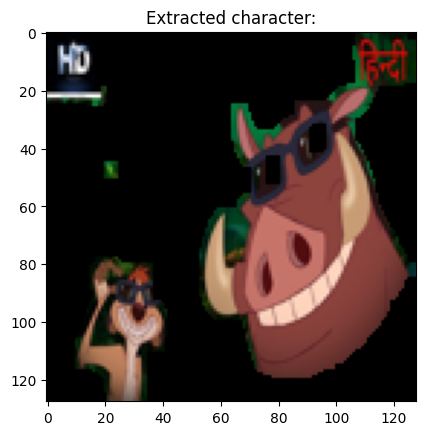

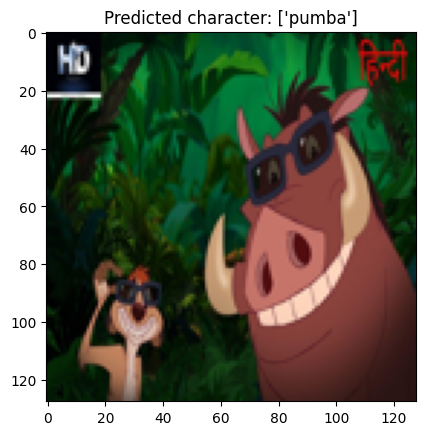

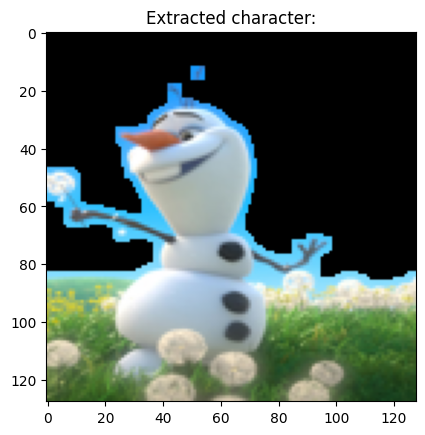

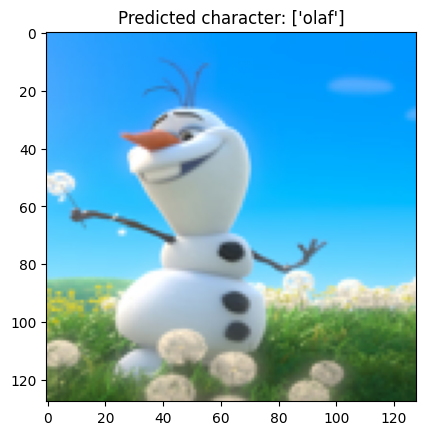

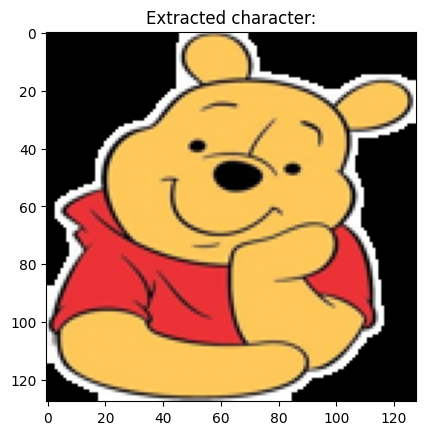

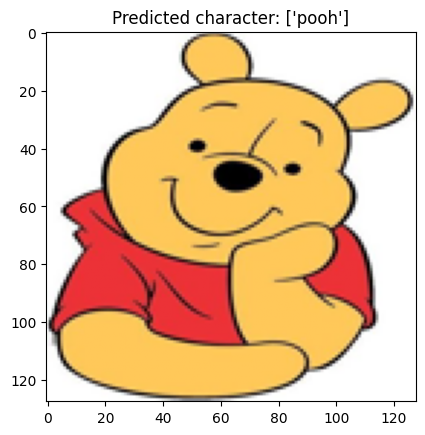

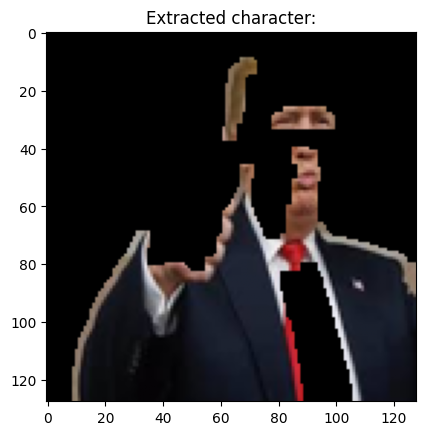

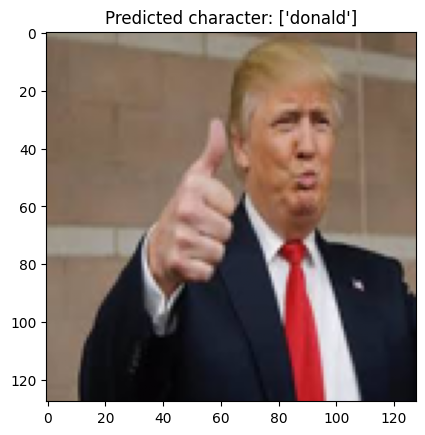

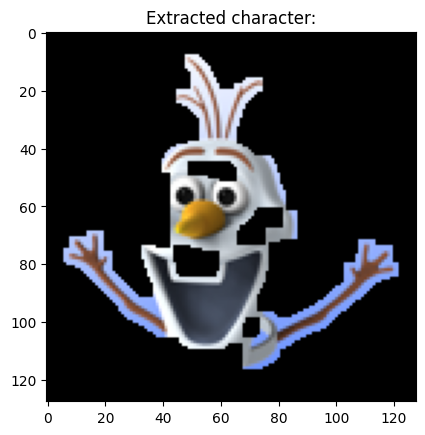

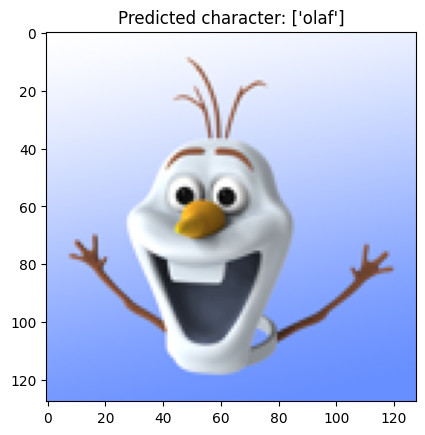

In [28]:
# Select 3 random images from the test set
random_indices = random.sample(range(dataset_showcase.shape[0]), 7)

for i in random_indices:
    # Process the image
    image = dataset_showcase[i]
    extracted_character = extract_character_from_image(image)

   
    plt.imshow(extracted_character, cmap='gray')
    plt.title(f'Extracted character:')
    plt.show()

    selected_character_features = extract_combined_features(extracted_character)
    
    # Flatten the image
    flattened_image = selected_character_features.flatten().reshape(1, -1)
    
    # Predict the label
    predicted_label = forest.predict(flattened_image)
    
    # Visualize the image and the label
    plt.imshow(image, cmap='gray')
    plt.title(f'Predicted character: {predicted_label}')
    plt.show()

### Train a Convolutional Neural Network 

A Convolutional Neural Network is trained as this is the traditional and most widely used approach for handling image data. It is also the approach that yields best resuts, however, as neural networks are to be furthere explored in advanced courses, we choose not to focus on this model and rather only use it to compare its performance to the previously trained ones.

In [24]:
X_cnn = dataset
y_cnn = labels

# Transform the label values to integers and then to one-hot encoded vectors so they are
# compatible with the activation function in the output layer of the CNN
le = LabelEncoder()
y_cnn_encoded = le.fit_transform(y_cnn)
Y_cnn = to_categorical(y_cnn_encoded, num_classes=7)

X_train_cnn, X_test_cnn, Y_train_cnn, Y_test_cnn = train_test_split(X_cnn, Y_cnn, stratify = Y_cnn)

In [25]:
model = Sequential()

# Convolutional layer to detect low level features like edges and colors
model.add(Conv2D(32, (3,3), activation = 'relu', input_shape = (128,128,3)))

# Reduce the width and height of the image by a factor of 2 to decrease the computational complexity
model.add(MaxPooling2D(pool_size = (2,2)))

# Turn off 25% of the neurons in the previous layer during each training epoch to prevent overfitting
model.add(Dropout(0.25)) 

# Second convolutional layer to detect more complex patterns
model.add(Conv2D(64, (3,3), activation = 'relu'))

model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Hidden layer with 64 neurons to extract features from the flattened input data
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(0.25))

# Output layer with 7 neurons (one for each class)
model.add(Dense(units = 7, activation = 'softmax'))

# The Adam optimizer adjusts the learning rate for each weight in the model individually for better training results
adam = optimizers.Adam(learning_rate = 0.001)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])


history = model.fit(X_train_cnn, Y_train_cnn, epochs = 10, batch_size = 16, validation_split = 0.3, verbose = 1)

c:\Users\uafa6\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 0.1421 - loss: 4.2670 - val_accuracy: 0.1810 - val_loss: 1.9439
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.2334 - loss: 1.9243 - val_accuracy: 0.3714 - val_loss: 1.8702
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.3578 - loss: 1.6644 - val_accuracy: 0.4571 - val_loss: 1.4593
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.5011 - loss: 1.2094 - val_accuracy: 0.6000 - val_loss: 1.1679
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 0.6896 - loss: 0.8088 - val_accuracy: 0.6286 - val_loss: 1.1780
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.8391 - loss: 0.5498 - val_accuracy: 0.6857 - val_loss: 0.9199
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.8889 - loss: 0.3083 - val_accuracy: 0.7238 - val_loss: 0.8982
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.9308 - loss: 0.2290 - val_accuracy: 0.

__Note__    
We can see that with a CNN better results can be achieved, in this case, we have reached around 80% accuracy on test data. Adding an additional convolutional layer to identify more complex features would increase the accuracy even more, however, that would also significantly affect the computational complexity of the model.

In [26]:
print("Accuracy on test data: {}".format(model.evaluate(X_test_cnn, Y_test_cnn)))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7214 - loss: 1.0223
Accuracy on test data: [0.8993645310401917, 0.7435897588729858]


## Conclusion

We can conclude that we have successfully achieved our goal. Our model is capable of extracting characters from images and correctly identifying them in most cases. The model performs particularly well when the background is clean, due to the effectiveness of clustering techniques in such conditions.

The accuracy for the Random Forest classifier on the validation set is 69.15%, while the Convolutional Neural Network (CNN) achieves an accuracy of 76%. This indicates that the CNN is a better option for this task. However, given our poor knowledge about deep learning(for now), we found it valuable to explore traditional machine learning algorithms like Random Forest, k-Nearest Neighbors (kNN), and Support Vector Machines (SVM) for this problem.

Our dataset comprises approximately 600 images, which is relatively small. Increasing the dataset size in future work could further enhance the model's performance and reliability.
